In [9]:
import pandas as pd
import numpy as np
import geopandas as gpd
from pysal.model import mgwr
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import matplotlib

import libpysal
import spreg
import esda

import os

In [3]:
df = pd.read_csv("../02 Data/modeling.csv")
gdf = gpd.read_file("../02 Data/shp/merge_all.shp")

In [4]:
df['Geography'] = df['Geography'].astype(str)
merge = pd.merge(gdf, df, left_on="geoid20", right_on="Geography", how="right")

len(merge)

286

In [5]:
x_1 = merge[[
        'Geography',
         'his_num_311_per_property',
         'neighbor_his_num_per_property',
         'snow_depth',
         'percent_below_poverty',
         'percent_civilian_unemployed',
         'per_capita_income',
         'percent_no_highschool',
         'percent_65older',
         'percent_17younger',
         'percent_household_disability',
         'percent_single_parent_household',
         'percent_minority',
         'percent_notwell_english',
         'percent_singleunits',
         'percent_multiunit',
         'percent_mobile_homes',
         'percent_owneroccupiedunit',
         'percent_crowding',
         'percent_group_quarters',
         'median_year_properties_built',
         'median_value_properties_built',
         'percent_no_vehicle',
         '311_index_per_property'
        ]]

x_1 = x_1.set_index("Geography")
y = x_1.pop("311_index_per_property")

# Standardization function
def standarize_data(data, stats):
    return (data - stats['mean'])/ stats['std']

x_1_stats = x_1.describe().transpose()
x_2 = standarize_data(x_1,x_1_stats)

w = libpysal.weights.Queen.from_dataframe(merge)
moran = esda.Moran(merge["311_index_per_property"], w)
print("moran I: " + str(moran.I))

y_name = "311_index_per_property"
y = np.array(merge["311_index_per_property"]).T

x_names = [
         'his_num_311_per_property',
         'neighbor_his_num_per_property',
         'snow_depth',
         'percent_below_poverty',
         'percent_civilian_unemployed',
         'per_capita_income',
         'percent_no_highschool',
         'percent_65older',
         'percent_17younger',
         'percent_household_disability',
         'percent_single_parent_household',
         'percent_minority',
         'percent_notwell_english',
         'percent_singleunits',
         'percent_multiunit',
         'percent_mobile_homes',
         'percent_owneroccupiedunit',
         'percent_crowding',
         'percent_group_quarters',
         'median_year_properties_built',
         'median_value_properties_built',
         'percent_no_vehicle'
]

x = np.array([x_2[var] for var in x_names]).T

# lag model
error_model = spreg.ML_Error(
    y,
    x,
    w=w,
    name_y=y_name,
    name_x=x_names
)

moran I: 0.2107144748390494


C:\Users\ryanz\AppData\Local\Temp\ipykernel_16048\102347822.py:38: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(merge)
C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\spreg\ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


In [6]:
error_model.pr2

0.5274745879760776

In [7]:
y_pred = error_model.predy
rmse = mean_squared_error(y , y_pred, squared=False)
print("RMSE of GWR: ", rmse)

RMSE of GWR:  3.6579785420553588


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [8]:
print(error_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :311_index_per_property                Number of Observations:         286
Mean dependent var  :     10.9277                Number of Variables   :          23
S.D. dependent var  :      5.3303                Degrees of Freedom    :         263
Pseudo R-squared    :      0.5275
Log likelihood      :   -772.4152
Sigma-square ML     :     12.8142                Akaike info criterion :    1590.830
S.E of regression   :      3.5797                Schwarz criterion     :    1674.918

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        10

In [10]:
features = [
    'CONSTANT',
         'his_num_311',
         'neighbor_his_num',
         'snow_depth',
         'percent_below_poverty',
         'percent_civilian_unemployed',
         'per_capita_income',
         'percent_no_highschool',
         'percent_65older',
         'percent_17younger',
         'percent_household_disability',
         'percent_single_parent_household',
         'percent_minority',
         'percent_notwell_english',
         'pop',
         'percent_singleunits',
         'percent_multiunit',
         'percent_mobile_homes',
         'percent_owneroccupiedunit',
         'percent_crowding',
         'percent_group_quarters',
         'building_count',
         'percent_no_vehicle',
    "lambda"
]

In [11]:
np.set_printoptions(suppress = True)
# feature importance table
df_coeffi = pd.DataFrame({'feature':features}).set_index('feature')
coefficients1 = error_model.betas.round(4)
df_coeffi['0_x'] = coefficients1
pvalue = [row[1] for row in error_model.z_stat]
df_coeffi['0_y'] = list(pvalue)
df_coeffi[["0_x"]] = df_coeffi[["0_x"]].astype(str)

for i in range(len(df_coeffi)):
    if df_coeffi["0_y"][i] < 0.001:
        df_coeffi["0_x"][i] = df_coeffi["0_x"][i] + "***"
    if df_coeffi["0_y"][i] < 0.01 and df_coeffi["0_y"][i] >= 0.001:
        df_coeffi["0_x"][i] = df_coeffi["0_x"][i] + "**"
    if df_coeffi["0_y"][i] < 0.05 and df_coeffi["0_y"][i] >= 0.01:
        df_coeffi["0_x"][i] = df_coeffi["0_x"][i] + "*"

C:\Users\ryanz\AppData\Local\Temp\ipykernel_18228\2523309838.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coeffi["0_x"][i] = df_coeffi["0_x"][i] + "***"
C:\Users\ryanz\AppData\Local\Temp\ipykernel_18228\2523309838.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coeffi["0_x"][i] = df_coeffi["0_x"][i] + "**"


In [12]:
df_coeffi

,0_x,0_y
feature,,
CONSTANT,32.7399***,0.000000e+00
his_num_311,9.0988***,4.316581e-32
neighbor_his_num,0.666,3.178078e-01
snow_depth,2.6268**,3.245192e-03
percent_below_poverty,0.1136,9.025848e-01
percent_civilian_unemployed,-0.5079,4.017082e-01
per_capita_income,1.1491,2.182052e-01
percent_no_highschool,0.2563,7.321278e-01
percent_65older,0.1293,8.651747e-01


In [13]:
df_coeffi.to_csv("C:/Users/ryanz/OneDrive/Desktop/co.csv")

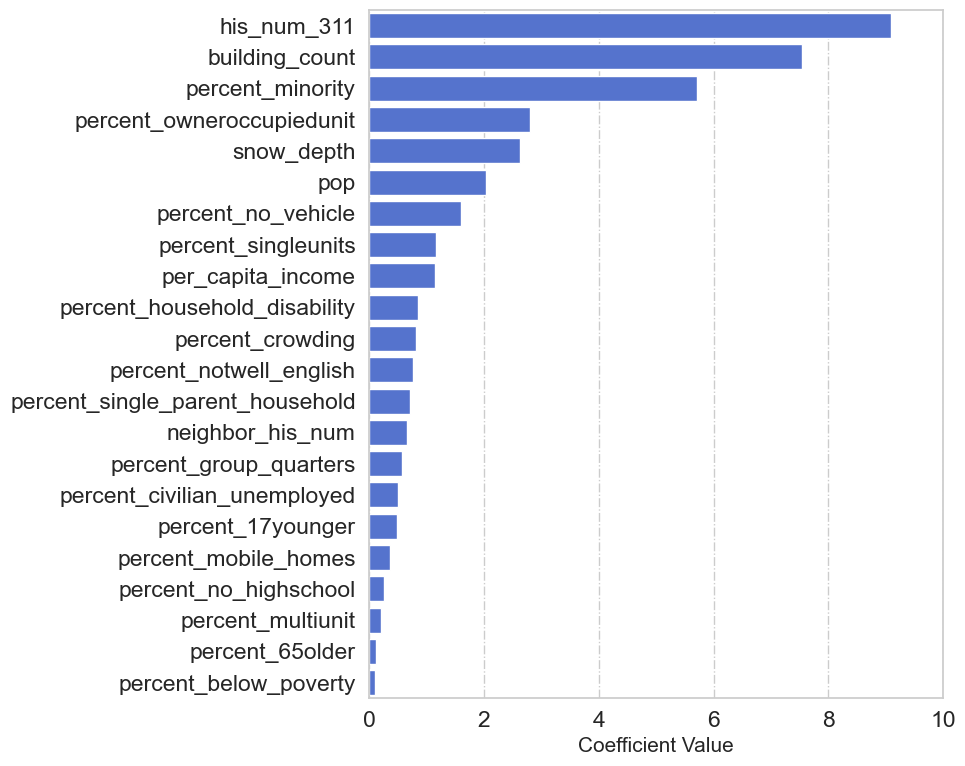

In [14]:
df_coeffi = pd.DataFrame({'feature':features}).set_index('feature')
coefficients1 = error_model.betas.round(4)
df_coeffi['0_x'] = coefficients1
pvalue = [row[1] for row in error_model.z_stat]
df_coeffi['0_y'] = list(pvalue)
df_coeffi["abs"] = df_coeffi["0_x"].apply(lambda x : abs(x))
df_coeffi.reset_index(drop=False, inplace=True)
df_coeffi = df_coeffi.sort_values(by = ['abs'], ascending = False)
df_coeffi = df_coeffi[(df_coeffi['feature'] != "CONSTANT") & (df_coeffi['feature'] != "lambda")]

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 28}

matplotlib.rc('font', **font)

plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid",font_scale = 1.5)

ax = sns.barplot(y="feature", x="abs", data=df_coeffi, color = "royalblue")
plt.xlabel('Coefficient Value', fontsize=15)
plt.ylabel('')
plt.xlim(0,10)
plt.grid(axis = 'x', linestyle='-.')
plt.tight_layout()
# plt.savefig("../OLS_coefficients_NYC.png",dpi=300)

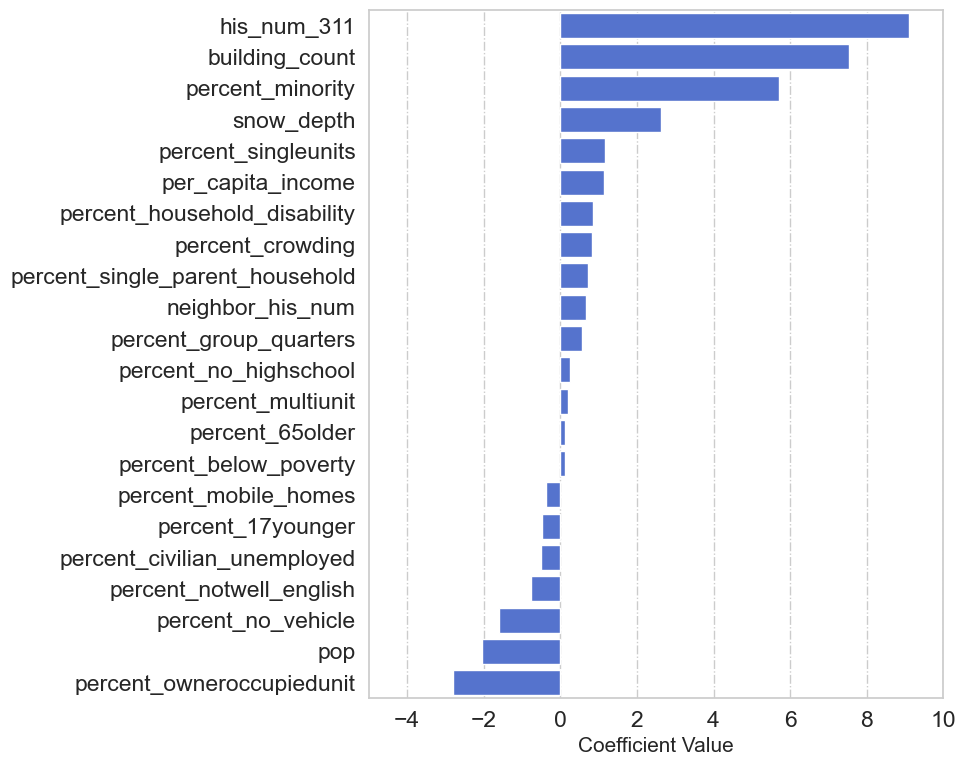

In [15]:
df_coeffi1 = df_coeffi.sort_values(by = ['0_x'], ascending = False)
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 28}

matplotlib.rc('font', **font)

plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid",font_scale = 1.5)

ax = sns.barplot(y="feature", x="0_x", data=df_coeffi1, color = "royalblue")
plt.xlabel('Coefficient Value', fontsize=15)
plt.ylabel('')
plt.xlim(-5,10)
plt.grid(axis = 'x', linestyle='-.')
plt.tight_layout()
plt.savefig("C:/Users/ryanz/OneDrive/Desktop/SE.png",dpi=300)